In [25]:
# Import packages
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm 
import shap
from sklearn.linear_model import LinearRegression
from sklearn import tree
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_validate,KFold
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import chi2_contingency
import scipy.stats as stats
import time
import shap

In [9]:
# Read Data
df = pd.read_csv('student-mat.csv', sep = ';')

# Tampilkan 5 baris teratas
df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


# Introduksi Data
1. school - student's school (binary: "GP" - Gabriel Pereira or "MS" - Mousinho da Silveira)
2. sex - student's sex (binary: "F" - female or "M" - male)
3. age - student's age (numeric: from 15 to 22)
4. address - student's home address type (binary: "U" - urban or "R" - rural)
5. famsize - family size (binary: "LE3" - less or equal to 3 or "GT3" - greater than 3)
6. Pstatus - parent's cohabitation status (binary: "T" - living together or "A" - apart)
7. Medu - mother's education (numeric: 0 - none,  1 - primary education (4th grade), 2 – 5th to 9th grade, 3 – secondary education or 4 – higher education)
8. Fedu - father's education (numeric: 0 - none,  1 - primary education (4th grade), 2 – 5th to 9th grade, 3 – secondary education or 4 – higher education)
9. Mjob - mother's job (nominal: "teacher", "health" care related, civil "services" (e.g. administrative or police), "at_home" or "other")
10. Fjob - father's job (nominal: "teacher", "health" care related, civil "services" (e.g. administrative or police), "at_home" or "other")
11. reason - reason to choose this school (nominal: close to "home", school "reputation", "course" preference or "other")
12. guardian - student's guardian (nominal: "mother", "father" or "other")
13. traveltime - home to school travel time (numeric: 1 - <15 min., 2 - 15 to 30 min., 3 - 30 min. to 1 hour, or 4 - >1 hour)
14. studytime - weekly study time (numeric: 1 - <2 hours, 2 - 2 to 5 hours, 3 - 5 to 10 hours, or 4 - >10 hours)
15. failures - number of past class failures (numeric: n if 1<=n<3, else 4)
16. schoolsup - extra educational support (binary: yes or no)
17. famsup - family educational support (binary: yes or no)
18. paid - extra paid classes within the course subject (Math or Portuguese) (binary: yes or no)
19. activities - extra-curricular activities (binary: yes or no)
20. nursery - attended nursery school (binary: yes or no)
21. higher - wants to take higher education (binary: yes or no)
22. internet - Internet access at home (binary: yes or no)
23. romantic - with a romantic relationship (binary: yes or no)
24. famrel - quality of family relationships (numeric: from 1 - very bad to 5 - excellent)
25. freetime - free time after school (numeric: from 1 - very low to 5 - very high)
26. goout - going out with friends (numeric: from 1 - very low to 5 - very high)
27. Dalc - workday alcohol consumption (numeric: from 1 - very low to 5 - very high)
28. Walc - weekend alcohol consumption (numeric: from 1 - very low to 5 - very high)
29. health - current health status (numeric: from 1 - very bad to 5 - very good)
30. absences - number of school absences (numeric: from 0 to 93)

these grades are related with the course subject, Math or Portuguese:

31. G1 - first period grade (numeric: from 0 to 20)
31. G2 - second period grade (numeric: from 0 to 20)
32. G3 - final grade (numeric: from 0 to 20, output target)

In [10]:
# Gunakan fitur yang terkait dengan gaya hidup/mental health
feats = ['school', 'sex', 'age', 'studytime','schoolsup','famsup','paid', 
         'nursery', 'higher', 'activities','romantic',
         'famrel', 'freetime','goout','Dalc','Walc','health',
         'absences','G1','G2','G3']

# Filter data hanya pada fitur-fitur tersebut
df_sub = df[feats]

# Cek informasi data
print("")
print('INFORMASI DATA')
print('---------------')
print("")
print(df_sub.info())

# Cek Missing Values dan Duplikat
print("")
print('MISSING VALUES')
print('---------------')
print("")
print(df_sub.isnull().sum())

print("")
print('DUPLIKAT DATA')
print('---------------')
print("")
print(df_sub[df_sub.duplicated()])


INFORMASI DATA
---------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 21 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      395 non-null    object
 1   sex         395 non-null    object
 2   age         395 non-null    int64 
 3   studytime   395 non-null    int64 
 4   schoolsup   395 non-null    object
 5   famsup      395 non-null    object
 6   paid        395 non-null    object
 7   nursery     395 non-null    object
 8   higher      395 non-null    object
 9   activities  395 non-null    object
 10  romantic    395 non-null    object
 11  famrel      395 non-null    int64 
 12  freetime    395 non-null    int64 
 13  goout       395 non-null    int64 
 14  Dalc        395 non-null    int64 
 15  Walc        395 non-null    int64 
 16  health      395 non-null    int64 
 17  absences    395 non-null    int64 
 18  G1          395 non-null    int64 
 19  G2          395 n

* Data ini mengandung 395 entri dengan 18 fitur 
* Data ini tidak mengandung nilai kosong dan duplikat
* Ada beberapa fitur binary yang dijadikan object, perlu diubah menjadi fitur numerik

In [11]:
# Encode menjadi numerik
encode_feats = ['schoolsup','famsup','paid','nursery','higher','activities','romantic']
encode_map = {'yes': 1,
             'no': 0}
for feat in encode_feats:
    df_sub[feat] = df_sub[feat].apply(lambda value: encode_map[value])

# Kategorikan siswa berdasarkan interval 15-17, 18-20, 21-22
dict_age_cat = {15: '15-17',
               16: '15-17',
               17: '15-17',
               18: '18-20',
               19: '18-20',
               20: '18-20',
               21: '21-22',
               22: '21-22'}

# Buat fitur baru berisi kategori usia
df_sub['age_cat'] = df_sub['age'].map(dict_age_cat)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


# Exploratory Data Analysis (EDA)

## Distribusi Nilai Ujian Matematika

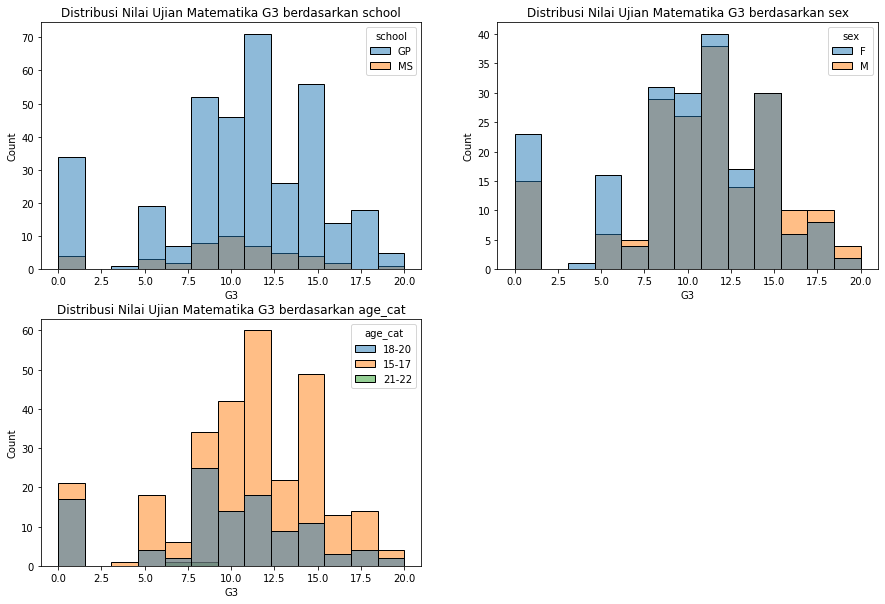

In [12]:
# Buat list berisi grade
category = ['school','sex','age_cat']
# Buat subplot
fig, axes = plt.subplots(2,2, figsize = (15,10))

# Plot
for i, ax in enumerate(axes.flatten()[:20]):
  # do stuff to ax
  if i < len(category):
    sns.histplot(data = df_sub,
                 x = 'G3',
                 hue = category[i],
                 palette = 'tab10',
                 ax = ax)
    ax.set_title(f'Distribusi Nilai Ujian Matematika G3 berdasarkan {category[i]}')
    ax.grid(False)

axes[-1, -1].axis('off')
plt.show()

In [14]:
# Buat summary statistics dari setiap kategori
df_sub.groupby(['school']).agg({'G3':['mean','median','max','min','count']})

G3                     
             mean median max min count
school                                
GP      10.489971   11.0  20   0   349
MS       9.847826   10.0  19   0    46

In [15]:
# Buat summary statistics dari setiap kategori
df_sub.groupby(['sex']).agg({'G3':['mean','median','max','min','count']})

G3                     
          mean median max min count
sex                                
F     9.966346   10.0  19   0   208
M    10.914439   11.0  20   0   187

In [16]:
# Buat summary statistics dari setiap kategori
df_sub.groupby(['age_cat']).agg({'G3':['mean','median','max','min','count']})

G3                     
              mean median max min count
age_cat                                
15-17    10.834507   11.0  20   0   284
18-20     9.376147   10.0  19   0   109
21-22     7.500000    7.5   8   7     2

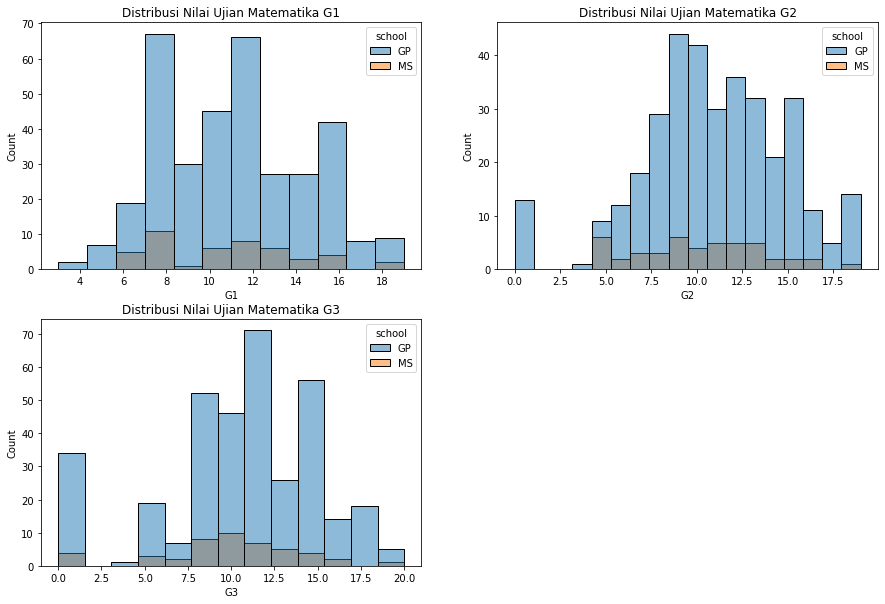

In [13]:
# Buat list berisi grade
grades = ['G1','G2','G3']

# Buat subplots
fig, axes = plt.subplots(2,2, figsize = (15,10))

# Plot
for i, ax in enumerate(axes.flatten()[:20]):
  # do stuff to ax
  if i < len(grades):
    sns.histplot(data = df_sub,
                 x = grades[i],
                 hue = 'school',
                 ax = ax)
    ax.set_title(f'Distribusi Nilai Ujian Matematika {grades[i]}')
    ax.grid(False)

axes[-1, -1].axis('off')
plt.show()

Dari diagram histogram di atas, sekolah GP cenderung memiliki siswa yang lebih banyak mencetak nilai ujian matematika yang tinggi dibandingkan sekolah MS. Hal ini disebabkan karena ketimpangan jumlah siswa sekolah GP dengan MS

In [15]:
# Summary statistics nilai ujian matematika
df_sub.groupby(['school'])[['G1','G2','G3']].agg(['mean','max','min'])

G1                 G2                 G3        
             mean max min       mean max min       mean max min
school                                                         
GP      10.939828  19   3  10.782235  19   0  10.489971  20   0
MS      10.673913  19   6  10.195652  18   5   9.847826  19   0

Secara rata-rata nilai ujian matematika Sekolah GP cenderung lebih tinggi dibandingkan Sekolah MS. Nilai maksimum ujian matematika berkisar di 18-20 dan nilai minimum ujian matematika berkisar di 0 - 6

In [19]:
# Jumlah siswa berdasarkan sex
df_sub['sex'].value_counts()

F    208
M    187
Name: sex, dtype: int64

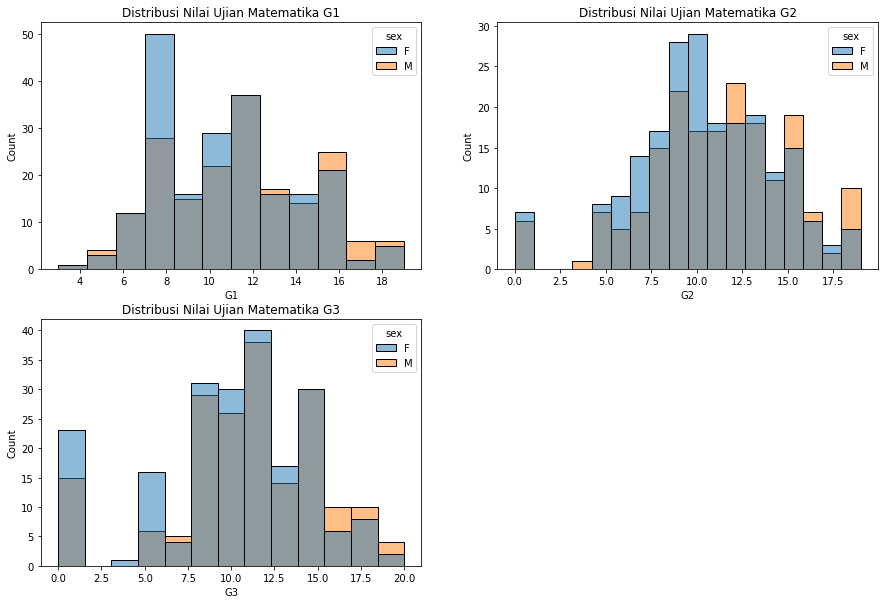

In [16]:
# Buat subplots
fig, axes = plt.subplots(2,2, figsize = (15,10))

# Plot
for i, ax in enumerate(axes.flatten()[:20]):
  # do stuff to ax
  if i < len(grades):
    sns.histplot(data = df_sub,
                 x = grades[i],
                 hue = 'sex',
                 ax = ax)
    ax.set_title(f'Distribusi Nilai Ujian Matematika {grades[i]}')
    ax.grid(False)

axes[-1, -1].axis('off')
plt.show()

In [22]:
# Summary statistics nilai ujian matematika
df_sub.groupby(['sex'])[['G1','G2','G3']].agg(['mean','max','min'])

G1                 G2                 G3        
          mean max min       mean max min       mean max min
sex                                                         
F    10.620192  19   4  10.389423  18   0   9.966346  19   0
M    11.229947  19   3  11.074866  19   0  10.914439  20   0

Jumlah siswa perempuan cenderung sedikit lebih banyak dibandingkan jumlah siswa laki-laki. Siswa laki-laki secara rata-rata mencetak skor yang lebih tinggi dibandingkan siswa perempuan.

In [28]:
# Kategorikan siswa berdasarkan interval 15-17, 18-20, 21-22
dict_age_cat = {15: '15-17',
               16: '15-17',
               17: '15-17',
               18: '18-20',
               19: '18-20',
               20: '18-20',
               21: '21-22',
               22: '21-22'}

# Buat fitur baru berisi kategori usia
df_sub['age_cat'] = df_sub['age'].map(dict_age_cat)

C:\Users\Asus\AppData\Local\Temp\ipykernel_16436\299037160.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub['age_cat'] = df_sub['age'].map(dict_age_cat)


0      18-20
1      15-17
2      15-17
3      15-17
4      15-17
       ...  
390    18-20
391    15-17
392    21-22
393    18-20
394    18-20
Name: age_cat, Length: 395, dtype: object

Mayoritas siswa berusia 16 tahun

C:\Users\Asus\Anaconda3\lib\site-packages\seaborn\distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


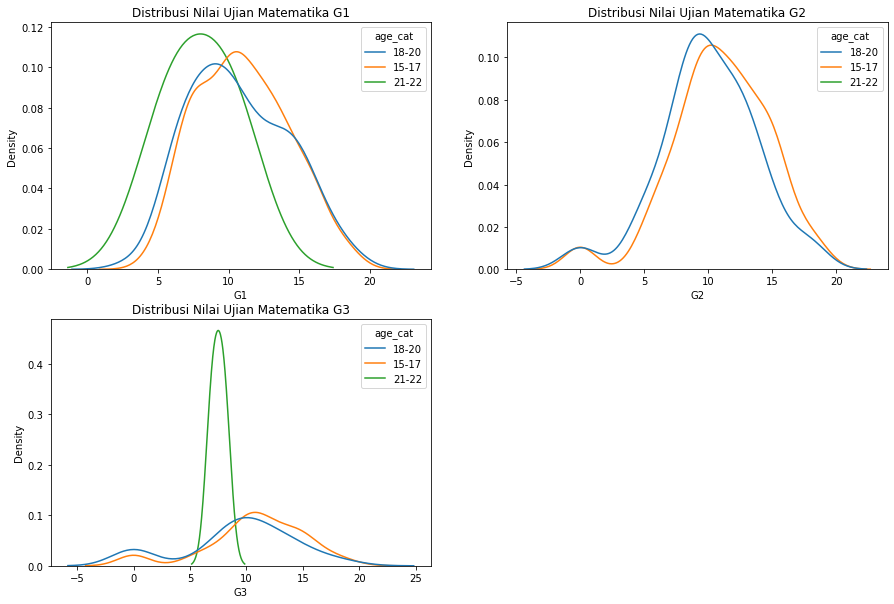

In [30]:
# Buat subplots
fig, axes = plt.subplots(2,2, figsize = (15,10))

# Plot
for i, ax in enumerate(axes.flatten()[:20]):
  # do stuff to ax
  if i < len(grades):
    sns.kdeplot(data = df_sub,
                 x = grades[i],
                 hue = 'age_cat',
                 common_norm = False,
                 ax = ax)
    ax.set_title(f'Distribusi Nilai Ujian Matematika {grades[i]}')
    ax.grid(False)

axes[-1, -1].axis('off')
plt.show()

In [31]:
# Summary statistics nilai ujian matematika
df_sub.groupby(['age_cat'])[['G1','G2','G3']].agg(['mean','max','min'])

G1                 G2                 G3        
              mean max min       mean max min       mean max min
age_cat                                                         
15-17    11.010563  19   4  10.992958  19   0  10.834507  20   0
18-20    10.697248  19   3  10.036697  18   0   9.376147  19   0
21-22     8.000000  10   6   8.000000   8   8   7.500000   8   7

* Pada ujian G1, G2, dan G3, siswa berusia 15-17 tahun, cenderung memiliki rerata lebih tinggi dibandingkan siswa berusia 18-20 dan 21-22

## Analisis Multivariat

### Hubungan Akademik dengan Nilai Ujian G3

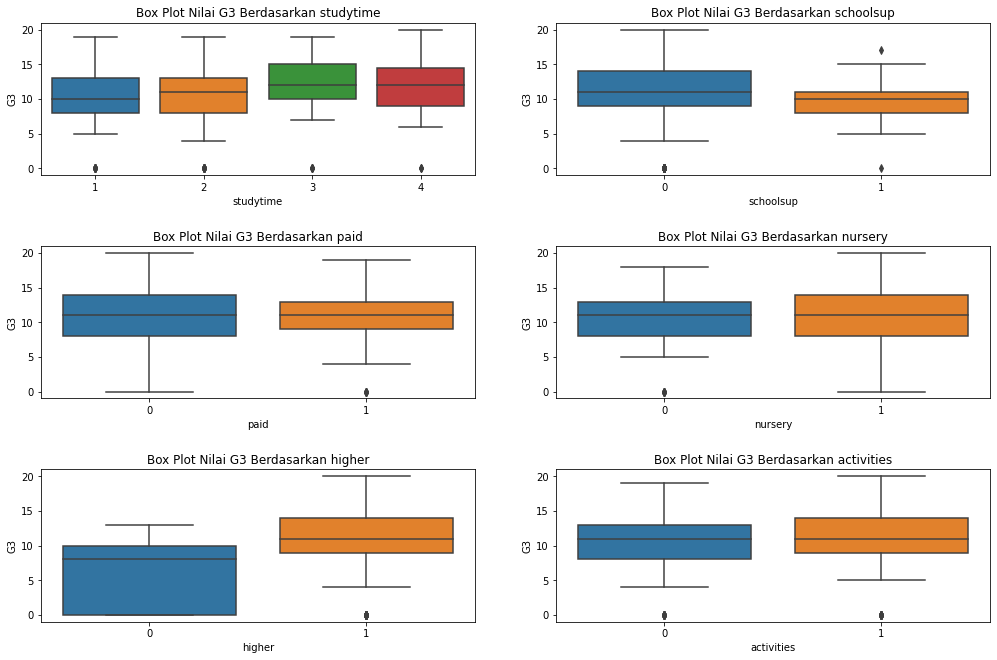

In [60]:
# Pilih fitur yang terkait dengan aktivitas sekolah
school_act = ['studytime', 'schoolsup','paid','nursery','higher','activities']

# Buat subplots
fig, axes = plt.subplots(3,2, figsize = (15,10))
fig.tight_layout(pad = 5.0)

# Plot
for i, ax in enumerate(axes.flatten()[:20]):
  # do stuff to ax
  if i < len(school_act):
    sns.boxplot(data = df_sub,
                 x = school_act[i],
                 y = 'G3',
                 ax = ax)
    ax.set_title(f'Box Plot Nilai G3 Berdasarkan {school_act[i]}')
    ax.grid(False)

plt.show()

Korelasi: 0.03424731615006932


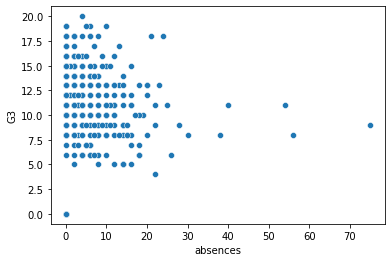

In [63]:
# Make scatterplot
print('Korelasi:', df_sub['absences'].corr(df_sub['G3']))
sns.scatterplot(data = df_sub, x = 'absences', y = 'G3')
plt.show()

* Siswa yang belajar lebih dari 5 jam cenderung memiliki skor G3 yang lebih tinggi secara rata-rata
* Siswa tanpa bantuan ekstra edukasi dari sekolah memiliki skor G3 yang lebih tinggi secara rata-rata
* Siswa yang menggunakan kursus tambahan memiliki rerata skor G3 yang sama dengan yang tidak mengambil kursus tambahan 
* Siswa yang mengambil sekolah keperawatan cenderung memiliki rerata yang sama dengan yang tidak mengambil sekolah keperawatan
* Siswa yang ingin melanjutkan ke pendidikan lanjut memiliki rerata skor G3 yang lebih tinggi dengan yang tidak
* Siswa yang mengambil ekskur memiliki rerata skor G3 yang sama dengan yang mengambil tidak mengambil ekskur
* Terdapat korelasi yang kecil antara absensi dengan skor G3, tapi mayoritas siswa yang memiliki skor G3 yang tinggi hanya absen 0 - 10 hari

In [71]:
# Uji korelasi dengan Point Biserial
for i in range(len(school_act)):
    # Measure correlation
    corr = stats.pointbiserialr(df_sub[school_act[i]], df_sub['G3'])[0]
    print(f"Korelasi antara {school_act[i]} dengan G3:", corr)

Korelasi antara studytime dengan G3: 0.09781968965319629
Korelasi antara schoolsup dengan G3: -0.08278821499316318
Korelasi antara paid dengan G3: 0.10199624071669919
Korelasi antara nursery dengan G3: 0.051567900910917584
Korelasi antara higher dengan G3: 0.18246461785815746
Korelasi antara activities dengan G3: 0.016099701295814367


* Terdapat korelasi yang kecil antara aktivitas pembelajaran dengan nilai ujian G3

### Hubungan Gaya Hidup dengan Nilai Ujian G3

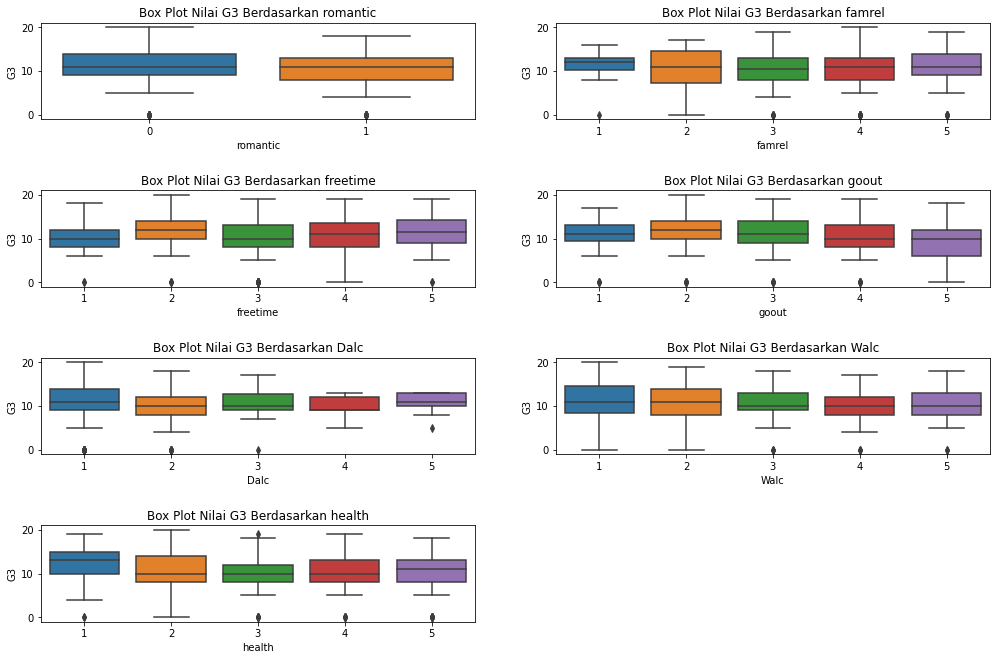

In [75]:
# Pilih fitur yang terkait gaya hidup
lifestyle_feats = ['romantic','famrel','freetime','goout','Dalc','Walc','health']

# Buat subplots
fig, axes = plt.subplots(4,2, figsize = (15,10))
fig.tight_layout(pad = 5.0)

# Plot
for i, ax in enumerate(axes.flatten()[:20]):
  # do stuff to ax
  if i < len(lifestyle_feats):
    sns.boxplot(data = df_sub,
                x = lifestyle_feats[i],
                y = 'G3',
                ax = ax)
    ax.set_title(f'Box Plot Nilai G3 Berdasarkan {lifestyle_feats[i]}')
    ax.grid(False)

axes[-1][-1].axis('off')
plt.show()

* Siswa yang tidak menjalin hubungan romantis cenderung memiliki rerata skor G3 yang lebih tinggi dari yang menjalin hubungan romantis.
* Siswa yang hubungan dengan keluarganya kurang berkualitas memiliki rerata skor G3 yang lebih tinggi dari yang lebih baik
* Siswa dengan waktu luang yang kurang maupun yang banyak memiliki rerata skor G3 yang hampir sama
* Siswa yang jarang bermain dengan temannya cenderung memiliki rerata skor G3 yang lebih tinggi
* Siswa dengan konsumsi alkohol yang jarang cenderung memiliki rerata skor G3 yang lebih tinggi
* Siswa yang paling tidak sehat justru menghasilkan rerata skor G3 yang paling tinggi

In [76]:
# Uji korelasi dengan Point Biserial
for i in range(len(lifestyle_feats)):
    # Measure correlation
    corr = stats.pointbiserialr(df_sub[lifestyle_feats[i]], df_sub['G3'])[0]
    print(f"Korelasi antara {lifestyle_feats[i]} dengan G3:", corr)

Korelasi antara romantic dengan G3: -0.12996995016345012
Korelasi antara famrel dengan G3: 0.051363428881282175
Korelasi antara freetime dengan G3: 0.01130724030831301
Korelasi antara goout dengan G3: -0.132791473503329
Korelasi antara Dalc dengan G3: -0.0546600405667359
Korelasi antara Walc dengan G3: -0.05193932374224622
Korelasi antara health dengan G3: -0.06133460487712129


* Terdapat korelasi yang kecil antara gaya hidup dengan nilai ujian G3

# Prediksi

In [18]:
df_sub.head()

,school,sex,age,studytime,schoolsup,famsup,paid,nursery,higher,activities,...,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,age_cat
0,GP,F,18,2,1,0,0,1,1,0,...,3,4,1,1,3,6,5,6,6,18-20
1,GP,F,17,2,0,1,0,0,1,0,...,3,3,1,1,3,4,5,5,6,15-17
2,GP,F,15,2,1,0,1,1,1,0,...,3,2,2,3,3,10,7,8,10,15-17
3,GP,F,15,3,0,1,1,1,1,1,...,2,2,1,1,5,2,15,14,15,15-17
4,GP,F,16,2,0,1,1,1,1,0,...,3,2,1,2,5,4,6,10,10,15-17


In [21]:
# Pilih variabel prediktor dan target
X = df_sub.drop(['G1','G2','G3','age_cat','school','sex','age'], axis = 1)
y = df_sub['G3']

# Get dummies
X = pd.get_dummies(X, drop_first = True)

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Print ukuran
print('Ukuran data training:', X_train.shape)
print('Ukuran data test:', X_test.shape)

Ukuran data training: (316, 15)
Ukuran data test: (79, 15)


In [27]:
# Use sklearn
dt = tree.DecisionTreeRegressor()

# Fit KFold
kf = KFold(n_splits=10)
kf.get_n_splits(X)

for i, (train_index, test_index) in enumerate(kf.split(X)):
    start_time = time.time()
    print(f"Fold {i+1}:")
    print("-----------------")
    
    # Pilih subset
    X_train = X.iloc[train_index, :]
    X_test = X.iloc[test_index, :]
    y_train = y[train_index]
    y_test = y[test_index]
    
    # Cetak ukuran data
    print('Ukuran data training:', X_train.shape)
    print('Ukuran data test:', X_test.shape)
    
    # Fit model
    dt.fit(X_train, y_train)
    
    # Cetak waktunya
    end_time = time.time() - start_time
    print('Waktu Training:', end_time)
    
    # Prediksi model
    y_pred = dt.predict(X_test)
    
    # Hitung MSE
    mse = mean_squared_error(y_test, y_pred)
    
    # Cetak MSE 
    print('MSE:', mse)
    print("")

Fold 1:
-----------------
Ukuran data training: (355, 15)
Ukuran data test: (40, 15)
Waktu Training: 0.004999876022338867
MSE: 35.925

Fold 2:
-----------------
Ukuran data training: (355, 15)
Ukuran data test: (40, 15)
Waktu Training: 0.006002187728881836
MSE: 14.3625

Fold 3:
-----------------
Ukuran data training: (355, 15)
Ukuran data test: (40, 15)
Waktu Training: 0.007005214691162109
MSE: 23.05

Fold 4:
-----------------
Ukuran data training: (355, 15)
Ukuran data test: (40, 15)
Waktu Training: 0.0059814453125
MSE: 44.1

Fold 5:
-----------------
Ukuran data training: (355, 15)
Ukuran data test: (40, 15)
Waktu Training: 0.004999399185180664
MSE: 23.275

Fold 6:
-----------------
Ukuran data training: (356, 15)
Ukuran data test: (39, 15)
Waktu Training: 0.004000425338745117
MSE: 18.05128205128205

Fold 7:
-----------------
Ukuran data training: (356, 15)
Ukuran data test: (39, 15)
Waktu Training: 0.004996776580810547
MSE: 42.743589743589745

Fold 8:
-----------------
Ukuran data t

In [30]:
# Use sklearn
dt = tree.DecisionTreeRegressor()

# fit
dt.fit(X_train, y_train)

# Print prediction
y_pred = dt.predict(X_test)

# Print score
print('MSE:', mean_squared_error(y_test, y_pred))

MSE: 43.0


## Interpretasi

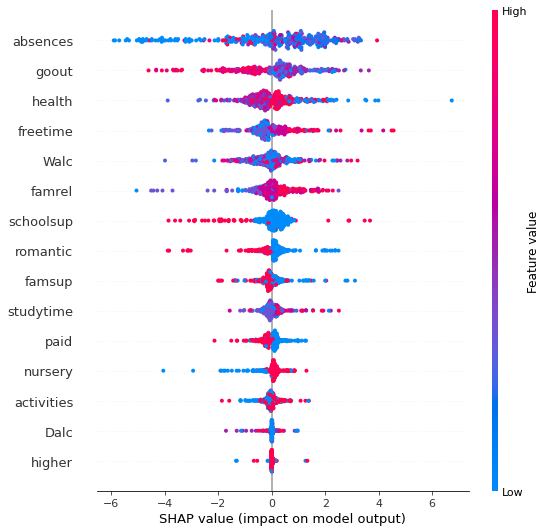

In [31]:
# SHAP EXPLAINER
explainer = shap.TreeExplainer(dt)
shap_values = explainer.shap_values(X_train)

# Plot
shap.summary_plot(shap_values, X_train)